# Import Libraries

In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Data Wrangling

In [198]:
df = pd.read_csv("Housing.csv")

print(df.info(), "\n")
df = df[(df['price'] < 12000000) & (df['price'] > 2000000)]
print(df['price'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None 

count    5.320000e+02
mean     4.758309e+06
std      1.727690e+06
min      2.100000e+06
25%      3.500000e+06
50%      4.357500e+06
75%      5.7400

In [199]:
df['mainroad'] = df['mainroad'].map({'yes': 1, 'no': 0})
df['guestroom'] = df['guestroom'].map({'yes': 1, 'no': 0})
df['basement'] = df['basement'].map({'yes': 1, 'no': 0})
df['hotwaterheating'] = df['hotwaterheating'].map({'yes': 1, 'no': 0})
df['airconditioning'] = df['airconditioning'].map({'yes': 1, 'no': 0})
df['prefarea'] = df['prefarea'].map({'yes': 1, 'no': 0})

df.drop_duplicates()

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,semi-furnished
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,semi-furnished
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,unfurnished
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,furnished


# Feature Engineering

In [200]:
correlation_matrix = df.corr()
price_correlation = correlation_matrix['price']
sorted_correlation = price_correlation.abs().sort_values(ascending=False)
print(sorted_correlation, "\n")

most_relevant_features = 5
selected_features = sorted_correlation.index[1 : most_relevant_features + 1]
print("Selected Features:", ', '.join(selected_features))

price              1.000000
area               0.518979
bathrooms          0.488893
airconditioning    0.449934
stories            0.413961
bedrooms           0.365058
parking            0.348441
prefarea           0.308136
mainroad           0.294261
guestroom          0.283042
basement           0.183375
hotwaterheating    0.103132
Name: price, dtype: float64 

Selected Features: area, bathrooms, airconditioning, stories, bedrooms


In [201]:
unwanted_features = ["mainroad", "guestroom", "basement", "hotwaterheating", "parking", "prefarea", "furnishingstatus"]
df = df.drop(unwanted_features, axis=1)
df.head()

,price,area,bedrooms,bathrooms,stories,airconditioning
4,11410000,7420,4,1,2,1
5,10850000,7500,3,3,1,1
6,10150000,8580,4,3,4,1
7,10150000,16200,5,3,2,0
8,9870000,8100,4,1,2,1


# Feature Engineering: ANOVA Test

In [202]:
continuous_features = ['price']
anova_selector = SelectKBest(score_func=f_regression, k=1)
x_continuous = df[continuous_features]
y = df['price']
x_anova = anova_selector.fit_transform(x_continuous, y)

# Feature Engineering: Chi-Squared Test

In [203]:
categorical_features = ['area', 'bathrooms', 'airconditioning', 'stories', 'bedrooms']
chi2_selector = SelectKBest(score_func=chi2, k=most_relevant_features)
x_categorical = df[categorical_features]
x_chi2 = chi2_selector.fit_transform(x_categorical, y)

# Feature Engineering: Merge ANOVA and Chi-Squared Tests

In [204]:
selected_features_anova = [continuous_features[i] for i in range(len(continuous_features)) if anova_selector.get_support()[i]]
selected_features_chi2 = [categorical_features[i] for i in range(len(categorical_features)) if chi2_selector.get_support()[i]]
selected_features = selected_features_anova + selected_features_chi2

# Build Prediction Model: Linear Regression

Mean Absolute Error: 0.00
R-squared: 1.00


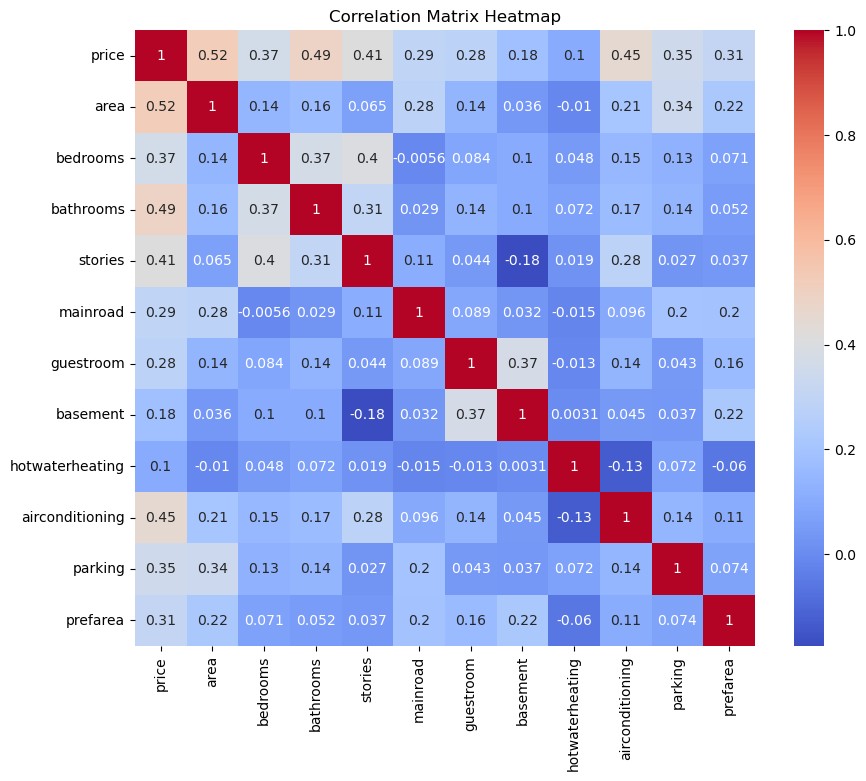

In [210]:
x = df[selected_features]
x = StandardScaler().fit_transform(x)
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

# Build Prediction Model: Cross-Validation

Cross-Validated MAE Scores:
0.0000000006
0.0000000023
0.0000000006
0.0000000008
0.0000000016
Mean MAE: 0.0000000012


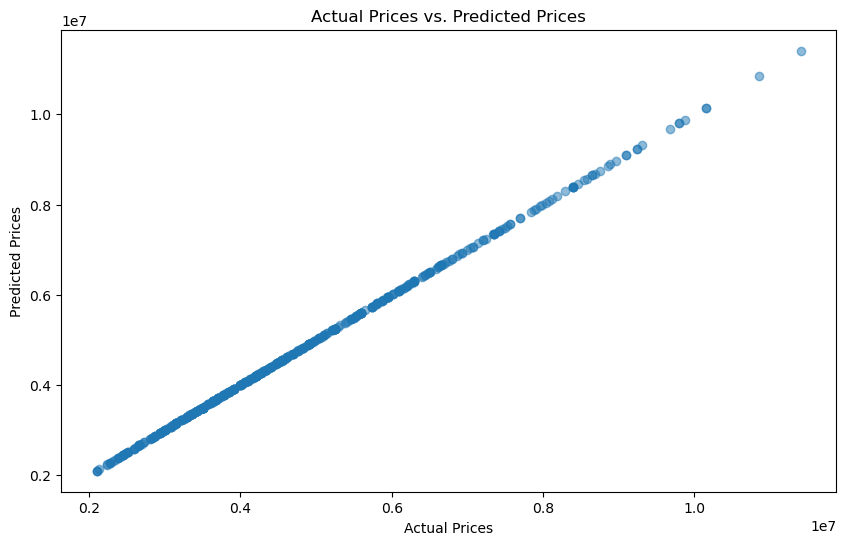

In [211]:
k = 5
mae_scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=k)
mae_scores = -mae_scores

print("Cross-Validated MAE Scores:")
for score in mae_scores:
    print(f"{score:.10f}")

mean_mae = mae_scores.mean()
print(f"Mean MAE: {mean_mae:.10f}")

y_cv_pred = cross_val_predict(model, x, y, cv=k)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_cv_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs. Predicted Prices")
plt.show()

# 1: Problem Statement
* **Dataset**: housing prices prediction
* **Target Variable**: prices
* **State Prediction Goal**: classification

# 3: Feature Engineering
* **Variables with little variance**: air conditioning
* **Features irrelevant to target variable**: none are, but some are less relevant
* **Highly-Correlated features**: area, bathrooms, airconditioning, stories, bedrooms
* **Algorithm require normalized/standardized data**: yes
* **Categorical variables need be changed to dummy variables**: yes

# 4: Build Prediction Model
* **Does data need to be balanced**: no
* **What do you use to validate result**: train_test_split
* **Which algorithm is appropriate for this problem**: linear regression
* **Which metrics do you use to evalutate prediction model**: MAE and R2
    - Chose MAE because: gives clear understanding of avg prediction error.
    - Chose R2 because: states how well model fits data (its high so its really good)

# Task: 2, 5, 6 dont have answerable questions